In [ ]:
import os, math, random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model, regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from arch import arch_model
import optuna
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import joblib
from tensorflow.keras.models import load_model

SEED = 42
np.random.seed(SEED); tf.random.set_seed(SEED); random.seed(SEED)
plt.style.use("seaborn-v0_8")

In [2]:
px_real = pd.read_csv(r"E:\data\stock_prices.csv",index_col="date",parse_dates=True).sort_index()

In [3]:
# ============================================================
# 1) SPLITS (TRAIN / VAL / TEST)  — FIXED DATES
# ============================================================
VAL_START, VAL_END = "2023-07-01", "2023-12-31"
TEST_START = "2024-01-01"

mask_train = px_real.index < VAL_START
mask_val   = (px_real.index >= VAL_START) & (px_real.index <= VAL_END)
mask_test  = px_real.index >= TEST_START

X_train = px_real.loc[mask_train]
X_val   = px_real.loc[mask_val]
X_test  = px_real.loc[mask_test]

print("\n--- Dataset split ---")
print("Train:", X_train.shape, "| Val:", X_val.shape, "| Test:", X_test.shape)

# ============================================================
# 2) PER-ASSET STANDARDIZATION (prices)
# ============================================================
scalers = {}
X_train_sc, X_val_sc, X_test_sc = X_train.copy(), X_val.copy(), X_test.copy()

for col in px_real.columns:
    sc = StandardScaler().fit(X_train[[col]])
    scalers[col] = sc
    X_train_sc[col] = sc.transform(X_train[[col]])
    X_val_sc[col]   = sc.transform(X_val[[col]])
    X_test_sc[col]  = sc.transform(X_test[[col]])

n_assets = X_train_sc.shape[1]

# ============================================================
# 3) AUTOENCODER (trained on TRAIN, early stop on VAL)
# ============================================================
input_layer = Input(shape=(n_assets,))
encoded = layers.Dense(32, activation="relu")(input_layer)
encoded = layers.Dense(16, activation="relu", name="latent_vector")(encoded)
decoded = layers.Dense(32, activation="relu")(encoded)
decoded = layers.Dense(n_assets, activation="linear")(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer="adam", loss="mse")

ae_hist = autoencoder.fit(
    X_train_sc.values, X_train_sc.values,
    validation_data=(X_val_sc.values, X_val_sc.values),
    epochs=80, batch_size=32, verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=8, restore_best_weights=True
    )]
)

encoder = Model(autoencoder.input, autoencoder.get_layer("latent_vector").output)

X_train_lat = encoder.predict(X_train_sc.values, verbose=0)
X_val_lat   = encoder.predict(X_val_sc.values,   verbose=0)
X_test_lat  = encoder.predict(X_test_sc.values,  verbose=0)

print("\n--- Latent shapes ---")
print("X_train_lat:", X_train_lat.shape, "| X_val_lat:", X_val_lat.shape, "| X_test_lat:", X_test_lat.shape)


# =====================================================================
# 1. COMMON HELPERS
# =====================================================================
def make_lags_series(series, k):
    """Return lagged DataFrame of series."""
    return pd.concat(
        [series.shift(i).rename(f"{series.name}_t-{i}") for i in range(1, k + 1)],
        axis=1
    )

def realized_vol_series(s, w=20):
    return s.rolling(w, min_periods=w).std()

def make_lags(s, k):
    return make_lags_series(s, k)


# =====================================================================
# 2. LAG OPTIMIZER (SAFE VERSION — MINIMAL PRINTS)
# =====================================================================
def lag_optimizer(px_df, lag_grid=range(2, 15), target_col=None,
                  train_frac=0.65, val_frac=0.2):
    """
    px_df: full price DataFrame (real or simulated)
    target_col: a pandas Series aligned with px_df index (mret or vol20)
    """
    y = target_col.copy().dropna()
    common_idx = y.index.copy()
    scores = []

    for k in lag_grid:
        X_lags = make_lags_series(y, k).dropna()

        # align indices
        X_lags = X_lags.loc[X_lags.index.intersection(common_idx)]
        y_k = y.loc[X_lags.index]

        n = len(X_lags)
        i_tr = int(n * train_frac)
        i_val = int(n * (train_frac + val_frac))

        X_train = X_lags.iloc[:i_tr]
        y_train = y_k.iloc[:i_tr]

        X_val = X_lags.iloc[i_tr:i_val]
        y_val = y_k.iloc[i_tr:i_val]

        if len(X_val) < 5:
            continue

        lr = LinearRegression()
        lr.fit(X_train, y_train)

        y_pred = lr.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))

        scores.append([k, rmse])

    scores_df = pd.DataFrame(scores, columns=["lag", "rmse"]).sort_values("rmse")
    best_lag = int(scores_df.iloc[0]["lag"])
    return best_lag, scores_df

# --- market returns & volatility for lag selection
rets_all = np.log(px_real).diff().dropna()
mret = rets_all.median(axis=1).rename("mret")
vol20 = mret.rolling(20).std().rename("vol20")

best_lag_ret, scores_ret = lag_optimizer(px_real, lag_grid=range(2, 15), target_col=mret)
best_lag_vol, scores_vol = lag_optimizer(px_real, lag_grid=range(2, 15), target_col=vol20)

print("Best lag for returns:", best_lag_ret)
print("Best lag for vol    :", best_lag_vol)


--- Dataset split ---
Train: (1383, 10) | Val: (126, 10) | Test: (441, 10)
Epoch 1/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9621 - val_loss: 1.8551
Epoch 2/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4150 - val_loss: 0.4438
Epoch 3/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1234 - val_loss: 0.4342
Epoch 4/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0656 - val_loss: 0.4344
Epoch 5/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0469 - val_loss: 0.4334
Epoch 6/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0396 - val_loss: 0.4223
Epoch 7/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0348 - val_loss: 0.4081
Epoch 8/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0304 - val_loss: 0.3839
Epoch 9/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0272 - val_loss: 0.3616
Epoch 10/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0248 - val_loss: 0.3434
Epoch 11/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0232 - val_loss: 0.327

In [ ]:
# =====================================================================
# 6. GARCH FEATURES (PER ASSET)
# =====================================================================
garch_vol_list = []
garch_resid_list = []

for col in px_real.columns:
    rets = np.log(px_real[col]).diff().dropna() * 100
    am = arch_model(rets, vol="Garch", p=1, q=1, dist="t")
    res = am.fit(update_freq=0, disp="off")

    vol = res.conditional_volatility.rename(f"{col}_garch_vol")
    std_resid = (res.resid / res.conditional_volatility).rename(f"{col}_garch_resid")

    vol = vol.reindex(px_real.index).ffill()
    std_resid = std_resid.reindex(px_real.index).ffill()

    garch_vol_list.append(vol)
    garch_resid_list.append(std_resid)

garch_feat_df = pd.concat(garch_vol_list + garch_resid_list, axis=1)

# =====================================================================
# 7. FEATURE ENGINEERING 
# =====================================================================
rets_all = np.log(px_real).diff().dropna()
rets_med = rets_all.median(axis=1).rename("mret")

lags_r = make_lags(rets_med, k=best_lag_ret)

vol_s = realized_vol_series(rets_med, w=5).rename("vol5")
vol_l = realized_vol_series(rets_med, w=20).rename("vol20")

lags_v = pd.concat(
    [make_lags(vol_s, best_lag_vol),
     make_lags(vol_l, best_lag_vol)],
    axis=1
)

q = vol_s.quantile([0.33, 0.66])
reg_low  = (vol_s <= q.iloc[0]).astype(int).rename("reg_low")
reg_mid  = ((vol_s > q.iloc[0]) & (vol_s <= q.iloc[1])).astype(int).rename("reg_mid")
reg_high = (vol_s > q.iloc[1]).astype(int).rename("reg_high")
regimes = pd.concat([reg_low, reg_mid, reg_high], axis=1)

px_dm = px_real.mean(axis=1) - px_real.mean(axis=1).rolling(120, min_periods=30).mean()
px_dm = px_dm.rename("market_lvl_dm")

ema = px_real.mean(axis=1).ewm(span=20, min_periods=10).mean().rename("market_ema20")

feat_df = pd.concat(
    [lags_r, lags_v, regimes, px_dm, ema, garch_feat_df],
    axis=1
)

# ---- STRICTLY CAUSAL FILL (NO B-FILL)
feat_df = feat_df.reindex(px_real.index).ffill()
feat_df = feat_df.dropna()

# ---- allow up to 40% NaNs per row (avoid killing dataset)
valid_mask = feat_df.isna().mean(axis=1) < 0.4
feat_df = feat_df.loc[valid_mask].ffill()

# =====================================================================
# 8. BUILD Z_t
# =====================================================================
common_train_idx = X_train_sc.index.intersection(feat_df.index)
common_val_idx   = X_val_sc.index.intersection(feat_df.index)
common_test_idx  = X_test_sc.index.intersection(feat_df.index)

F_train = feat_df.loc[common_train_idx].values
F_val   = feat_df.loc[common_val_idx].values
F_test  = feat_df.loc[common_test_idx].values

X_train_lat = X_train_lat[X_train_sc.index.get_indexer(common_train_idx)]
X_val_lat   = X_val_lat[X_val_sc.index.get_indexer(common_val_idx)]
X_test_lat  = X_test_lat[X_test_sc.index.get_indexer(common_test_idx)]

X_train_sc = X_train_sc.loc[common_train_idx]
X_val_sc   = X_val_sc.loc[common_val_idx]
X_test_sc  = X_test_sc.loc[common_test_idx]

Z_train = np.hstack([X_train_lat, F_train])
Z_val   = np.hstack([X_val_lat,   F_val])
Z_test  = np.hstack([X_test_lat,  F_test])

# =====================================================================
# 9. TARGETS ALIGNMENT
# =====================================================================
X_df = px_real.iloc[:-1]
y_df = px_real.iloc[1:]
y_df.index = X_df.index   # y_{t+1} aligned to t

# --- ensure targets exist for those feature dates
common_train_idx = common_train_idx.intersection(y_df.index)
common_val_idx   = common_val_idx.intersection(y_df.index)
common_test_idx  = common_test_idx.intersection(y_df.index)

y_train = y_df.loc[common_train_idx]
y_val   = y_df.loc[common_val_idx]
y_test  = y_df.loc[common_test_idx]

# --- scale targets
y_train_sc = y_train.copy()
y_val_sc   = y_val.copy()
y_test_sc  = y_test.copy()

for col in px_real.columns:
    sc = scalers[col]
    y_train_sc[col] = sc.transform(y_train[[col]])
    y_val_sc[col]   = sc.transform(y_val[[col]])
    y_test_sc[col]  = sc.transform(y_test[[col]])

# --- align current prices
X_train_sc = X_train_sc.loc[common_train_idx]
X_val_sc   = X_val_sc.loc[common_val_idx]
X_test_sc  = X_test_sc.loc[common_test_idx]

Xc_train = X_train_sc.values
Xc_val   = X_val_sc.values
Xc_test  = X_test_sc.values

# --- align Z as well (CRITICAL)
# --- TRUE index alignment for Z
Z_train = Z_train[X_train_sc.index.get_indexer(common_train_idx)]
Z_val = Z_val[X_val_sc.index.get_indexer(common_val_idx)]
Z_test = Z_test[X_test_sc.index.get_indexer(common_test_idx)]

# =====================================================================
# 10. SEQUENCES (SAFE WINDOW)
# =====================================================================
def build_sequence_dataset(Z, Xc, y, window):
    Z_seq, Xc_seq, y_seq = [], [], []
    for i in range(window, len(Z)):
        Z_seq.append(Z[i-window:i].reshape(-1))
        Xc_seq.append(Xc[i])
        y_seq.append(y[i])
    return np.array(Z_seq), np.array(Xc_seq), np.array(y_seq)

W = 10  # smaller window to ensure samples

Z_train_seq, Xc_train_seq, y_train_seq = build_sequence_dataset(Z_train, Xc_train, y_train_sc.values, W)
Z_val_seq,   Xc_val_seq,   y_val_seq   = build_sequence_dataset(Z_val,   Xc_val,   y_val_sc.values,   W)
Z_test_seq,  Xc_test_seq,  y_test_seq  = build_sequence_dataset(Z_test,  Xc_test,  y_test_sc.values,  W)

print("Train sequences:", Z_train_seq.shape)
print("Val sequences:", Z_val_seq.shape)
print("Test sequences:", Z_test_seq.shape)


# =====================================================================
# 11. RESNET BIAS-CORRECTED (SEQUENCE VERSION)
# =====================================================================
def residual_block(x, units, dropout=0.05):
    sc = x
    x = layers.Dense(units, activation='relu',
                     kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(units, kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Add()([x, sc])
    return layers.Activation('relu')(x)

def build_resnet_bias_corrected(input_dim, n_assets,n_blocks=1,hidden_units=155):
    inp_Z = layers.Input(shape=(input_dim,))
    inp_curr_sc = layers.Input(shape=(n_assets,))
    x = layers.Dense(hidden_units, activation='relu')(inp_Z)
    for _ in range(n_blocks):
        x = residual_block(x, hidden_units)
    delta = layers.Dense(n_assets)(x)
    yhat_sc = layers.Add()([inp_curr_sc, delta])

    model = Model([inp_Z, inp_curr_sc], yhat_sc)
    model.compile(optimizer=tf.keras.optimizers.Adam(3e-4),
        loss=tf.keras.losses.Huber(delta=1.0)
    )
    return model

model_resnet = build_resnet_bias_corrected(input_dim=Z_train_seq.shape[1], n_assets=n_assets)

Train sequences: (1343, 710)
Val sequences: (116, 710)
Test sequences: (430, 710)


Epoch 1/120
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.2059 - val_loss: 2.5822 - learning_rate: 3.0000e-04
Epoch 2/120
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2975 - val_loss: 1.1827 - learning_rate: 3.0000e-04
Epoch 3/120
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1261 - val_loss: 0.6855 - learning_rate: 3.0000e-04
Epoch 4/120
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0959 - val_loss: 0.4962 - learning_rate: 3.0000e-04
Epoch 5/120
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0793 - val_loss: 0.3436 - learning_rate: 3.0000e-04
Epoch 6/120
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0693 - val_loss: 0.3786 - learning_rate: 3.0000e-04
Epoch 7/120
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0604 - val_loss: 0.1881 - learning_rate: 3.0000e-04
Epoch 8/120
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0552 - val_loss: 0.1169 - learning_rate: 3.0000e-04
Epoch 9/120
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0526 - val_loss: 0.1822 - learning_

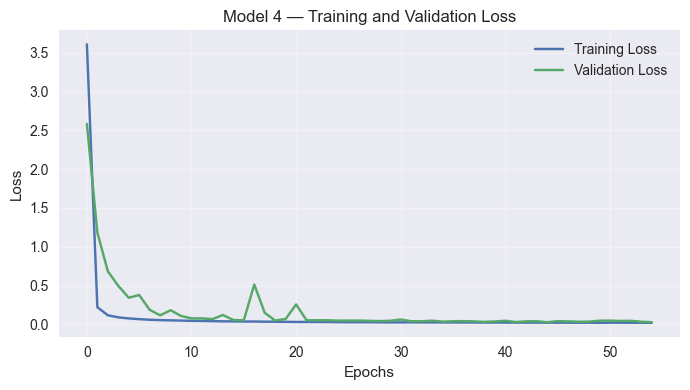

Training time (Model 4): 7.89 seconds


In [ ]:
# ==========================================================
# TRAINING TIME (ONLY — NO EXTRA TRAINING, NO HISTORY)
# ==========================================================
start_time = time.time()

hist = model_resnet.fit(
    [Z_train_seq, Xc_train_seq], y_train_seq,
    validation_data=([Z_val_seq, Xc_val_seq], y_val_seq),
    epochs=120, batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=5)
    ],
    verbose=1
)

plt.figure(figsize=(7, 4))
plt.plot(hist.history["loss"], label="Training Loss")
plt.plot(hist.history["val_loss"], label="Validation Loss")
plt.title("Model 4 — Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

end_time = time.time()

print(f"Training time (Model 4): {end_time - start_time:.2f} seconds")

In [6]:
model_resnet.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 710)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 155)       │    110,205 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 155)       │     24,180 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 155)       │        620 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 155)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 155)       │     24,180 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 155)       │          0 │ dense_5[0][0],    │
│                     │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 155)       │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 10)        │      1,560 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 10)        │          0 │ input_layer_2[0]… │
│                     │                   │            │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 481,617 (1.84 MB)

 Trainable params: 160,435 (626.70 KB)

 Non-trainable params: 310 (1.21 KB)

 Optimizer params: 320,872 (1.22 MB)

Applied amplitude correction.
Applied bias baseline correction.

=== MODEL: Hybrid ResNet (Corrected) ===
RMSE (overall): 8.4505
MAE  (overall): 5.2316
R²   (overall): 0.9972

Per-asset metrics (sorted by RMSE):


,RMSE,MAE
SCHD,0.784536,0.606136
VZ,0.893347,0.674641
XOM,3.775639,2.887139
PG,4.301437,3.280989
CVX,5.761475,4.275208
AVGO,7.347488,5.002987
AMZN,7.376578,5.336282
CAT,9.619806,7.311107
MSFT,13.517135,10.573446
VOO,16.219927,12.368325


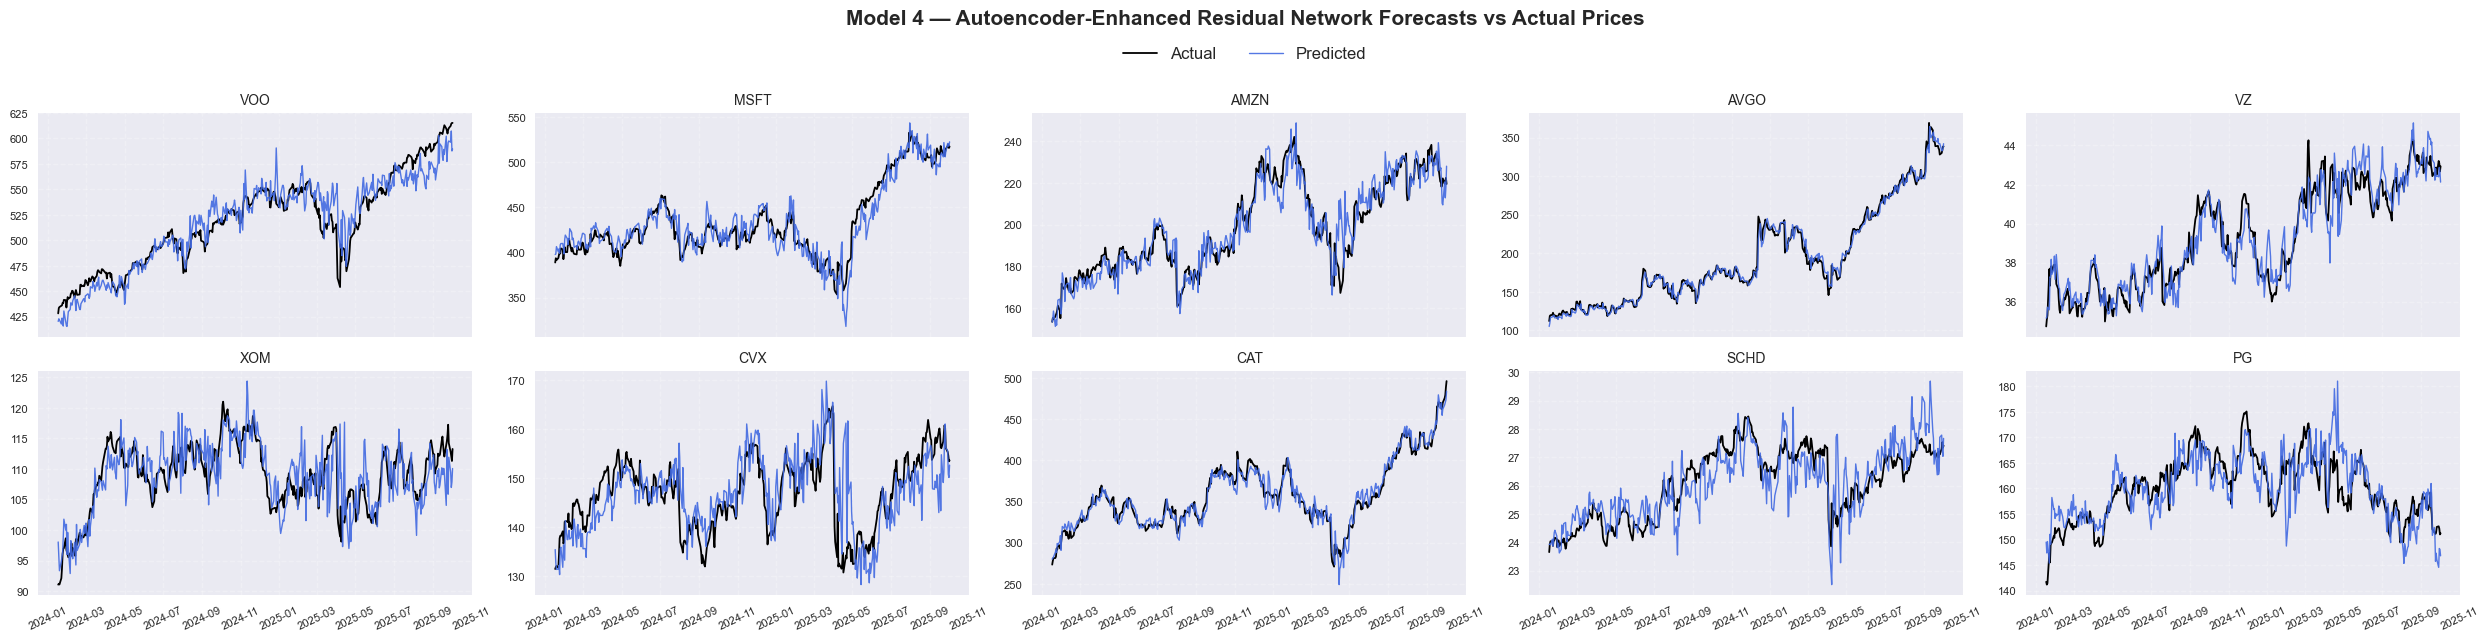

In [ ]:
# =====================================================================
# 8. FORECAST + INVERSE SCALE (TEST, SEQUENCE)
# =====================================================================

W = 10

# y_test_sc_seq aligned με τα sequences: πρώτη πρόβλεψη αντιστοιχεί στο index από W και μετά
y_test_sc_aligned = y_test_sc.iloc[W:]
y_test_real = y_test.loc[y_test_sc_aligned.index]

# predict
y_pred_sc = model_resnet.predict([Z_test_seq, Xc_test_seq], verbose=0)

# build correct index directly from y_test_sc
pred_index = y_test_sc.index[-len(y_pred_sc):]

y_pred_df = pd.DataFrame(
    y_pred_sc,
    index=pred_index,
    columns=px_real.columns
)

# inverse scale -> REAL prices
y_pred_real = y_pred_df.copy()

for col in px_real.columns:
    y_pred_real[col] = scalers[col].inverse_transform(
        y_pred_df[[col]]
    )

# align true values
y_test_real = y_test.loc[pred_index]

# =====================================================================
# 8.5 — FIX 1: AMPLITUDE (STD) CORRECTION
# =====================================================================
y_pred_amp = y_pred_real.copy()

for col in px_real.columns:
    true_std = y_test_real[col].std()
    pred_std = y_pred_real[col].std()

    if pred_std < 1e-8:
        continue

    c = true_std / pred_std  # scaling ratio

    y_pred_amp[col] = (
        y_pred_real[col].mean() +
        c * (y_pred_real[col] - y_pred_real[col].mean())
    )

print("Applied amplitude correction.")

# =====================================================================
# 8.6 — FIX 2: BASELINE BIAS CORRECTION
# =====================================================================
y_pred_corr = y_pred_amp.copy()

for col in px_real.columns:
    mean_true = y_test_real[col].mean()
    mean_pred = y_pred_amp[col].mean()
    shift = mean_true - mean_pred

    y_pred_corr[col] = y_pred_amp[col] + shift

print("Applied bias baseline correction.")

# =====================================================================
# 9. METRICS (USING FULL CORRECTED PREDICTIONS)
# =====================================================================
rmse_overall = np.sqrt(mean_squared_error(
    y_test_real.values.flatten(),
    y_pred_corr.values.flatten()
))
mae_overall  = mean_absolute_error(
    y_test_real.values.flatten(),
    y_pred_corr.values.flatten()
)
r2_overall   = r2_score(
    y_test_real.values.flatten(),
    y_pred_corr.values.flatten()
)

print("\n=== MODEL: Hybrid ResNet (Corrected) ===")
print(f"RMSE (overall): {rmse_overall:.4f}")
print(f"MAE  (overall): {mae_overall:.4f}")
print(f"R²   (overall): {r2_overall:.4f}")

metrics_per_asset = pd.DataFrame(index=px_real.columns,
                                 columns=["RMSE","MAE"], dtype=float)

for col in px_real.columns:
    metrics_per_asset.loc[col,"RMSE"] = np.sqrt(
        mean_squared_error(y_test_real[col], y_pred_corr[col])
    )
    metrics_per_asset.loc[col,"MAE"] = mean_absolute_error(
        y_test_real[col], y_pred_corr[col])
    
print("\nPer-asset metrics (sorted by RMSE):")
display(metrics_per_asset.sort_values("RMSE"))

# =====================================================================
# 10. PLOTS — STATIC MODEL (TEST SET, CORRECTED)
# =====================================================================
assets = px_real.columns
ncols = 5
nrows = math.ceil(len(assets) / ncols)

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(5*ncols, 3.2*nrows),
    sharex=True
)

axes = axes.ravel()

for i, col in enumerate(assets):
    ax = axes[i]

    # Actual
    ax.plot(y_test_real.index,y_test_real[col],color="black",lw=1.3,label="Actual")
    ax.plot(y_test_real.index,y_pred_corr[col],color="royalblue",lw=1.,alpha=0.9,label="Predicted")
    ax.set_title(col, fontsize=10)

    ax.grid(True, alpha=0.25, linestyle="--")
    ax.tick_params(axis="x", rotation=25, labelsize=8)
    ax.tick_params(axis="y", labelsize=8)

# remove empty axes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels,loc="upper center",bbox_to_anchor=(0.5, 0.96),ncol=2,frameon=False,fontsize=12)
fig.suptitle("Model 4 — Autoencoder-Enhanced Residual Network Forecasts vs Actual Prices",fontsize=15,fontweight="bold",y=0.995)
plt.tight_layout(rect=(0,0,1,0.94))
plt.show()

In [ ]:
def objective(trial):
    n_blocks = trial.suggest_int("n_blocks", 1, 3)
    hidden_units = trial.suggest_int("hidden_units", 64, 128, step=16)
    lr = trial.suggest_float("lr", 1e-4, 5e-4, log=True)

    model = build_resnet_bias_corrected(
        input_dim=Z_train_seq.shape[1],
        n_assets=n_assets,
        n_blocks=n_blocks,
        hidden_units=hidden_units
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss=tf.keras.losses.Huber()
    )

    hist = model.fit(
        [Z_train_seq, Xc_train_seq], y_train_seq,
        validation_data=([Z_val_seq, Xc_val_seq], y_val_seq),
        epochs=40,
        batch_size=32,
        verbose=0
    )

    return min(hist.history["val_loss"])


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

print("Best params:", study.best_params)

IndentationError: unexpected indent (1926253889.py, line 5)

In [ ]:
print("\n================ MODEL 4 — HYBRID RESNET (REAL DATA) ================")

# ---------------------------------------------------------------------
# DATASET SPLITS
# ---------------------------------------------------------------------
print("\n--- Dataset split (days) ---")
print("Train days :", X_train_sc.shape[0])
print("Val days   :", X_val_sc.shape[0])
print("Test days  :", X_test_sc.shape[0])
print("Assets     :", n_assets)

# ---------------------------------------------------------------------
# AUTOENCODER (LATENT FEATURES)
# ---------------------------------------------------------------------
print("\n--- Autoencoder latent representation ---")
print("Latent dimension (per timestep) :", X_train_lat.shape[1])

# ---------------------------------------------------------------------
# MARKET & GARCH FEATURES
# ---------------------------------------------------------------------
print("\n--- Market & volatility features (per timestep) ---")
print("Lagged market returns dims      :", lags_r.shape[1])
print("Lagged volatility dims          :", lags_v.shape[1])
print("Regime dummies                  :", regimes.shape[1])
print("Market level & EMA              :", 2, "(market_lvl_dm, market_ema20)")
print("GARCH features                  :", garch_feat_df.shape[1])

print("Total market features F_t       :", feat_df.shape[1])

# ---------------------------------------------------------------------
# FINAL INPUT VECTOR Z_t
# ---------------------------------------------------------------------
print("\n--- Final engineered input Z_t ---")
print("Z_t dimension (per timestep)    :", Z_train.shape[1])
print("Z_train shape                  :", Z_train.shape)
print("Z_val shape                    :", Z_val.shape)
print("Z_test shape                   :", Z_test.shape)

# ---------------------------------------------------------------------
# SEQUENCE CONSTRUCTION
# ---------------------------------------------------------------------
print("\n--- Sequence construction ---")
print("Sequence window length (W)      :", W)
print("Flattened input dim (W × Z_t)   :", Z_train_seq.shape[1])

print("Z_train_seq shape              :", Z_train_seq.shape)
print("Xc_train_seq (current prices)  :", Xc_train_seq.shape)
print("y_train_seq (targets)          :", y_train_seq.shape)

print("Z_val_seq shape                :", Z_val_seq.shape)
print("Z_test_seq shape               :", Z_test_seq.shape)

# ---------------------------------------------------------------------
# MODEL OUTPUT
# ---------------------------------------------------------------------
print("\n--- Model output ---")
print("Output dimension (assets)       :", y_train_seq.shape[1])

print("\n===============================================================")


================ MODEL 4 — HYBRID RESNET (REAL DATA) ================

--- Dataset split (days) ---
Train days : 1353
Val days   : 126
Test days  : 440
Assets     : 10

--- Autoencoder latent representation ---
Latent dimension (per timestep) : 16

--- Market & volatility features (per timestep) ---
Lagged market returns dims      : 10
Lagged volatility dims          : 20
Regime dummies                  : 3
Market level & EMA              : 2 (market_lvl_dm, market_ema20)
GARCH features                  : 20
Total market features F_t       : 55

--- Final engineered input Z_t ---
Z_t dimension (per timestep)    : 71
Z_train shape                  : (1353, 71)
Z_val shape                    : (126, 71)
Z_test shape                   : (440, 71)

--- Sequence construction ---
Sequence window length (W)      : 10
Flattened input dim (W × Z_t)   : 710
Z_train_seq shape              : (1343, 710)
Xc_train_seq (current prices)  : (1343, 10)
y_train_seq (targets)          : (1343, 10)
Z_val_

## new version

In [ ]:
#BASE_PATH = r"E:\models\ResNet_Hybrid_v71"
os.makedirs(BASE_PATH, exist_ok=True)

meta = {
    "assets": list(px_real.columns),
    "window": W,
    "latent_dim": X_train_lat.shape[1],
    "market_feat_dim": F_train.shape[1],
    "best_lag_ret": best_lag_ret,
    "best_lag_vol": best_lag_vol
}
model_resnet.save(os.path.join(BASE_PATH, "resnet_model.keras"))
encoder.save(os.path.join(BASE_PATH, "encoder_model.keras"))

joblib.dump(scalers, os.path.join(BASE_PATH, "scalers.pkl"))
joblib.dump(meta, os.path.join(BASE_PATH, "meta.pkl"))
print(meta)

[OK] Bundle saved.
{'assets': ['VOO', 'MSFT', 'AMZN', 'AVGO', 'VZ', 'XOM', 'CVX', 'CAT', 'SCHD', 'PG'], 'window': 10, 'latent_dim': 16, 'market_feat_dim': 55, 'best_lag_ret': 10, 'best_lag_vol': 10}
